# **Time Series Analysis**

Normally, the NYC subway system runs 24/7, but during Covid-19, the MTA shut off trains between 1 and 5 AM to disinfect them.

Started in mid-March 2020 (before the dataset begins). Officially ended May 17, 2021.

https://www.mta.info/safetravels

https://www.mta.info/press-release/mta-restore-24-hour-subway-service-monday-may-17



## **1. Setting Up Environment & Loading Data**

In [2]:
# Importing libraries
import pandas as pd # 1
import matplotlib.pyplot as plt # 2.2
import matplotlib.dates as mdates # 2.2
import scipy.stats as stats # 2.5
import numpy as np # 2.5
from statsmodels.tsa.seasonal import seasonal_decompose # 2.5
from sklearn.linear_model import LinearRegression # 2.5
import statsmodels.api as sm # 2.5
from scipy.stats import kendalltau # 2.5
from statsmodels.tsa.stattools import adfuller # 3.1
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 4.2
import itertools # 4.2
from statsmodels.tsa.statespace.sarimax import SARIMAX # 4.3
import warnings # 4.2
from statsmodels.tools.sm_exceptions import ConvergenceWarning # 4.2
from sklearn.metrics import mean_absolute_error, mean_squared_error # 4.2
#from pmdarima import auto_arima # 4.3

In [3]:
# Reading in data
df = pd.read_csv("../ridership.csv")

# Casting data types
df['date'] = pd.to_datetime(df['date'])
df['datetime'] = df['date'] + pd.to_timedelta(df['hour'], unit='h')

# Filtering out dates before June 2021
df = df[df['datetime'] >= pd.to_datetime('2021-06-01')]

# Hourly ridership data
hourly = df[['datetime', 'ridership']].set_index('datetime')

# Daily ridership data
daily = df[['date', 'ridership']].groupby('date').sum()

print(hourly.head())
print(daily.head())

                     ridership
datetime                      
2021-06-01 00:00:00      13073
2021-06-01 01:00:00       4888
2021-06-01 02:00:00       2450
2021-06-01 03:00:00       2875
2021-06-01 04:00:00      12392
            ridership
date                 
2021-06-01    2270076
2021-06-02    2354755
2021-06-03    2244535
2021-06-04    2316851
2021-06-05    1785164


## **2. Exploratory Data Analysis (EDA)**

### 2.1 Summary Statistics

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)
daily.describe().style.format("{:,.0f}")

,ridership
count,"1,310"
mean,"2,976,879"
std,"821,800"
min,"748,331"
25%,"2,276,226"
50%,"3,162,599"
75%,"3,649,970"
max,"4,570,716"


The dataset contains 1,310 days of daily ridership with an average of 2,976,879 daily riders.

### 2.2 Visualizing the Time Series

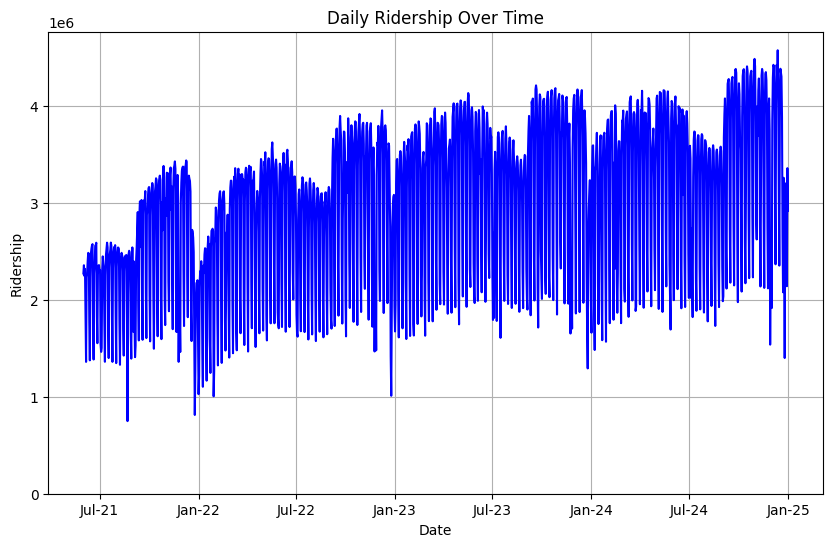

In [5]:
plt.figure(figsize=(10, 6))

plt.plot(daily.index, daily['ridership'], linestyle='-', marker='', color='b') # plot daily ridership over time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))  # format as mmm-dd
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # automatically choose date intervals
plt.ylim(0, None) # start y-axis at 0
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.title('Daily Ridership Over Time')
plt.grid(True)
plt.show()

Several key observations can be drawn from this visualization. First, the line's appearance as a thick block of blue suggests substantial variation in daily ridership over a short timeframe. That said, the graph aligns with the boxplot's findings (below), showing no obvious outliers, as the majority of the data points fall within the range of 1 to 4 million riders per day.

### 2.3 Outlier Detection

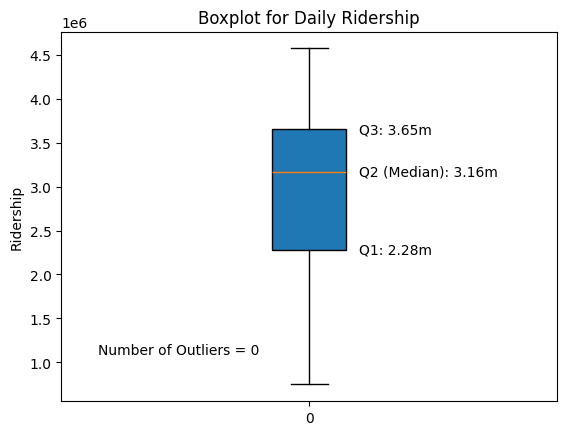

In [6]:
# Calculating quartiles
quartiles = np.percentile(daily['ridership'], [25, 50, 75])
Q1, Q2, Q3 = quartiles

# Calculating inner-quartile range
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Visualizing data with boxplot
bp = plt.boxplot(daily['ridership'], patch_artist=True, positions=[0])

outliers = len(daily[(daily['ridership'] > upper_bound) | (daily['ridership'] < lower_bound)])
for flier in bp['fliers']:
    flier.set(marker='o', color='red', alpha=0.75)

# Annotate quartiles
plt.text(0.1, Q1, f'Q1: {(Q1/1000000):.2f}m',
         verticalalignment='center', horizontalalignment='left')

plt.text(0.1, Q2, f'Q2 (Median): {(Q2/1000000):.2f}m',
         verticalalignment='center', horizontalalignment='left')

plt.text(0.1, Q3, f'Q3: {(Q3/1000000):.2f}m',
         verticalalignment='center', horizontalalignment='left')

plt.text(-0.1, Q1/2, f'Number of Outliers = {outliers}',
         verticalalignment='center', horizontalalignment='right')

# Labels
plt.ylabel('Ridership')
plt.title('Boxplot for Daily Ridership')

plt.show()

No data points lie outside the lower and upper bounds calculated using the standard IQR method. This is a positive outcome, as it means there are no outliers to distort the models, and there is no evidence of significant data errors (such as those potentially caused by human mistakes).

### 2.4 Rolling Statistics

In [7]:
# Calculate the rolling mean & rolling standard deviation on a 7 day cycle
rolling_mean = daily.rolling(window='7D').mean()[6:]
rolling_std = daily.rolling(window='7D').std()[6:]

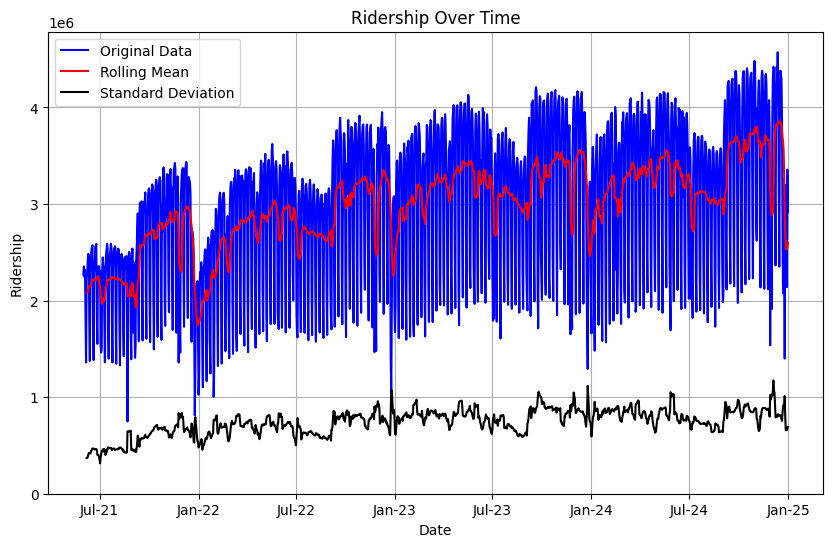

In [8]:
# Plot the rolling mean & rolling standard deviation
plt.figure(figsize=(10, 6))

plt.plot(daily, label='Original Data', linestyle='-', marker='', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', linestyle='-', marker='', color='red')
plt.plot(rolling_std, label='Standard Deviation', linestyle='-', marker='', color='black')

# Format the x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))  # Format as mmm-dd
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically choose date intervals

# Axis
plt.ylim(0, None)
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.title('Ridership Over Time')
plt.legend()
plt.grid(True)
plt.show()

### 2.5 Decomposing the Data

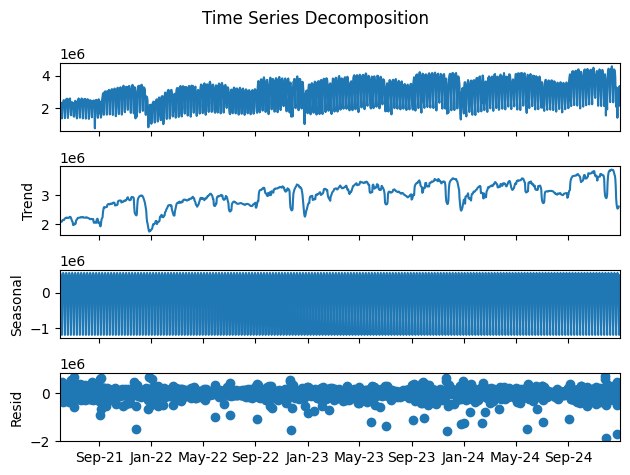

In [9]:
# Decompose data
decomposition = seasonal_decompose(daily, model='additive', period=7)

# Plot the decomposition
decomposition.plot()
plt.suptitle('Time Series Decomposition')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.tight_layout()
plt.show()

Let's begin by examining the trend component. At first glance, it's not immediately obvious whether there's an upward trend, so additional analysis will be needed to confirm this. To get started, we'll plot the original daily ridership data alongside the trend derived from the decomposition.

#### 2.5.1 Trend Component

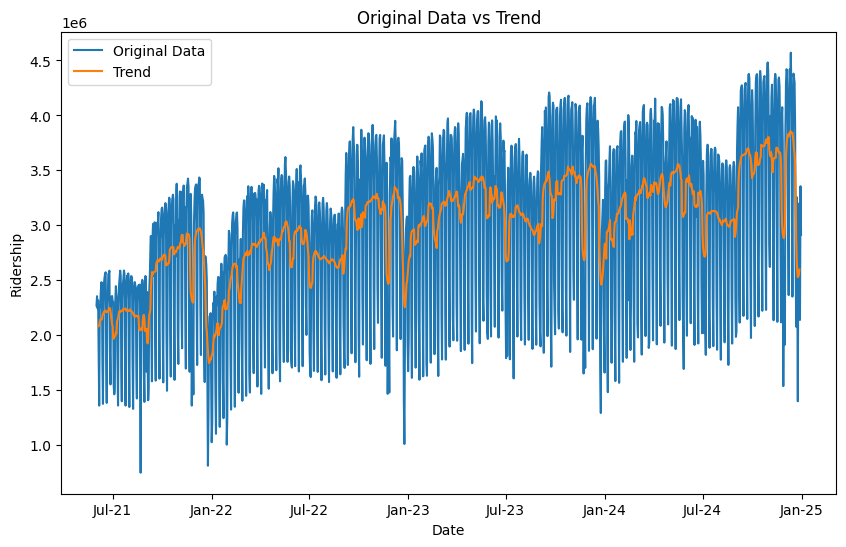

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(daily, label='Original Data') # plot actual data
plt.plot(decomposition.trend, label='Trend') # plot trend
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.title('Original Data vs Trend')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.show()

The graph suggests there might be a slight upward trend. To explore this further, we can fit a linear regression model to the trend component for a more detailed analysis.

In [11]:
# Fit linear regression model
trend_component = decomposition.trend.dropna()
x = np.arange(len(trend_component)).reshape(-1, 1)
y = trend_component.values

# Add constant to independent varaible for the intercept term
x_with_const = sm.add_constant(x)

# Fit OLS model
model = sm.OLS(y, x_with_const)
results = model.fit()

# Calculate residuals
residuals = decomposition.resid.dropna()

# Calculate predictions
y_pred = results.predict(x_with_const)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     1832.
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          1.19e-250
Time:                        19:55:34   Log-Likelihood:                -18196.
No. Observations:                1304   AIC:                         3.640e+04
Df Residuals:                    1302   BIC:                         3.641e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.408e+06   1.54e+04    156.433      0.0

In [12]:
# Hypothesis test on the slope (coefficient of x)
slope = results.params[1]
slope_std_err = results.bse[1]
t_value = slope / slope_std_err
p_value = results.pvalues[1]

print(f"Slope: {slope}")
print(f"Standard Error of Slope: {slope_std_err}")
print(f"t-value: {t_value}")
print(f"p-value: {p_value}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The slope is significantly different from zero.")
else:
    print("Fail to reject the null hypothesis: The slope is not significantly different from zero.")

Slope: 875.8800496116949
Standard Error of Slope: 20.461390745436383
t-value: 42.80647686702563
p-value: 1.1929052300159815e-250
Reject the null hypothesis: The slope is significantly different from zero.


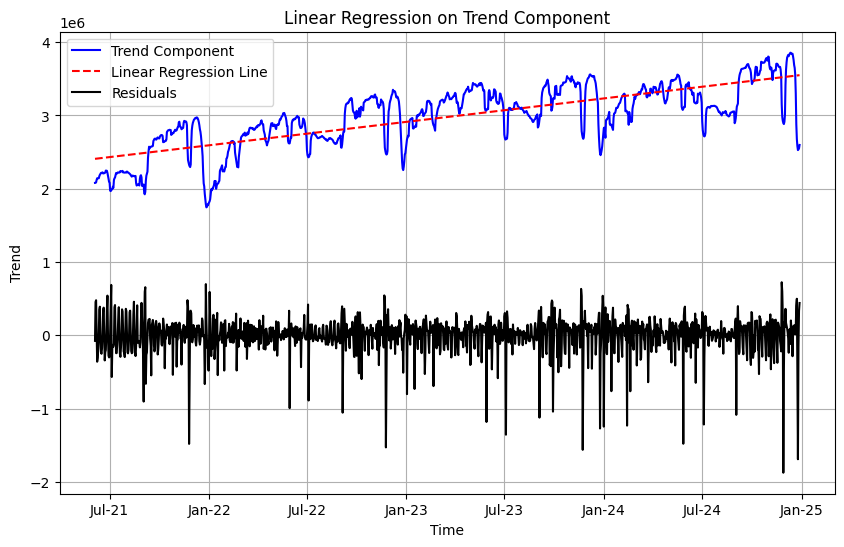

In [13]:
# Plot the trend component and the regression line
plt.figure(figsize=(10, 6))

plt.plot(trend_component.index, trend_component,
         label='Trend Component', color='blue')

plt.plot(trend_component.index, y_pred,
         label='Linear Regression Line', color='red', linestyle='--')

plt.plot(residuals, label='Residuals', color='black')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.title('Linear Regression on Trend Component')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.legend()
plt.grid(True)
plt.show()

The linear regression model produced a positive slope, suggesting the presence of an upward trend. This finding could impact future time series analysis, as de-trending the data might be necessary. However, the slope's magnitude is relatively small compared to the data, which operates on a scale in the millions. As a result, further testing is required to assess whether this slope is statistically significant.

Next, let's perform the Mann-Kendall test, which helps indicate if there's a trend in time series data.

In [14]:
tau, p_value = kendalltau(daily.index, daily)
# Print the results
print("Mann-Kendall Test Results:")
print(f"Kendall's tau: {tau:.3}")  # Kendall's tau correlation coefficient
print(f"p-value: {p_value:.3e}")    # p-value for significance testing

Mann-Kendall Test Results:
Kendall's tau: 0.307
p-value: 2.356e-62


Kendall's tau quantifies the strength and direction of a trend, with values ranging from -1 to 1. The results reveal a moderate upward trend, and the near-zero p-value confirms that this trend is statistically significant. These findings align with the linear regression model, which also identified a statistically significant trend in the data.



#### 2.5.2 Seasonality Component

Next, let's analyze the seasonality component, which was very difficult to initially interpret in the original decomposition graph. This is because the data is mainly on a weekly cycle, and there are so many cycles represented in the data, which results in a blue block when plotted all together. When zoomed in on a certain time period, the cycle becomes much clearer to look at. Below is a plot of the first 8 weeks of the data with every other week being highlighted in blue to demonstrate the seasonality aspect

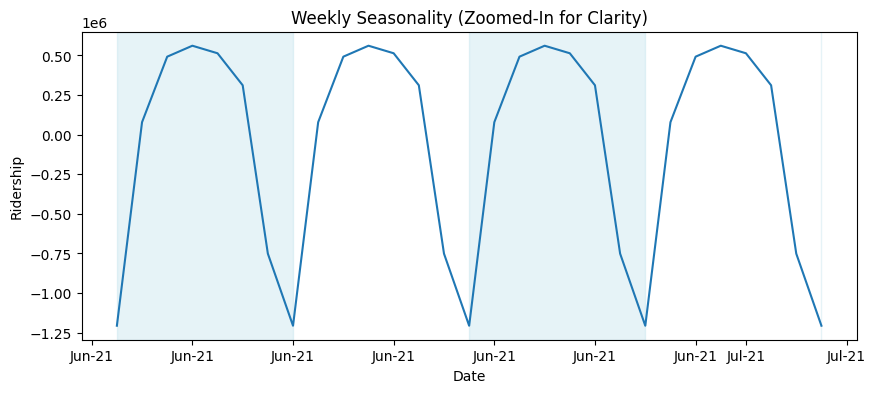

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(decomposition.seasonal[5:34])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

dates = decomposition.seasonal[5:34].index
start_date, end_date = min(dates), max(dates)

# Shade every other week (starting from the first Sunday)
shade = False  # toggle for shading
for i, date in enumerate(dates):
    if date.weekday() == 6:  # Sunday is represented by 6 in weekday()
        if i > 0:  # skip first Sunday to avoid shading before first week
            end_date = date
            plt.axvspan(start_date, end_date,
                        color='lightblue', alpha=0.3 if shade else 0)
        start_date = date
        shade = not shade  # toggle shading for the next week

# Shade the last week if necessary
if shade:
    plt.axvspan(start_date, dates[-1], color='lightblue', alpha=0.3)

plt.title('Weekly Seasonality (Zoomed-In for Clarity)')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.show()

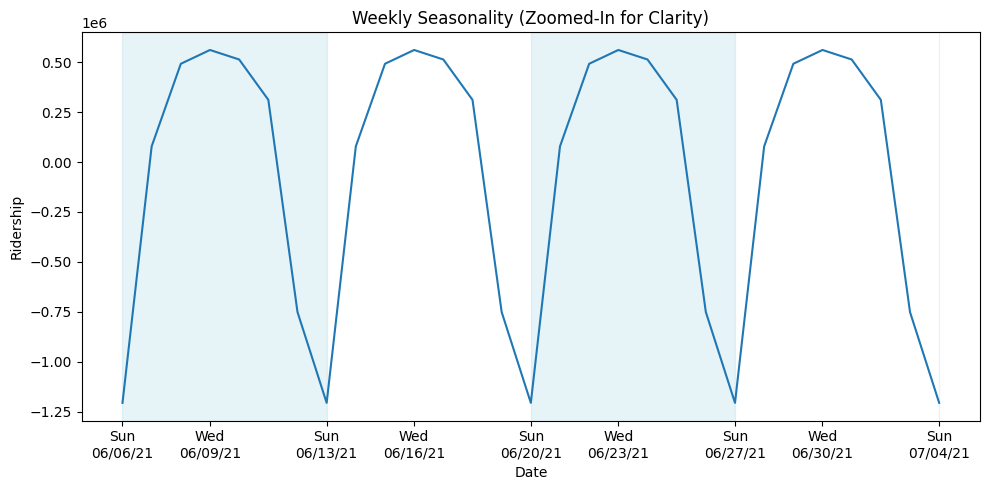

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(decomposition.seasonal[5:34])

# Custom formatter to show day name and date
def day_date_formatter(x, pos=None):
    date = mdates.num2date(x)
    if date.weekday() == 6:  # Sunday
        return f"Sun\n{date.strftime('%m/%d/%y')}"
    elif date.weekday() == 2:  # Wednesday
        return f"Wed\n{date.strftime('%m/%d/%y')}"
    return ""

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(day_date_formatter))

# Custom locator to place ticks on Sundays and Wednesdays
class SunWedLocator(mdates.DayLocator):
    def __init__(self):
        super().__init__(interval=1)

    def __call__(self):
        # Get the default ticks from DayLocator
        ticks = super().__call__()
        # Filter to only keep Sundays (6) and Wednesdays (2)
        return [t for t in ticks if mdates.num2date(t).weekday() in (2, 6)]

plt.gca().xaxis.set_major_locator(SunWedLocator())

dates = decomposition.seasonal[5:34].index
start_date, end_date = min(dates), max(dates)

# Shade every other week (starting from the first Sunday)
shade = False  # toggle for shading
for i, date in enumerate(dates):
    if date.weekday() == 6:  # Sunday is represented by 6 in weekday()
        if i > 0:  # skip first Sunday to avoid shading before first week
            end_date = date
            plt.axvspan(start_date, end_date,
                        color='lightblue', alpha=0.3 if shade else 0)
        start_date = date
        shade = not shade  # toggle shading for the next week

# Shade the last week if necessary
if shade:
    plt.axvspan(start_date, dates[-1], color='lightblue', alpha=0.3)

plt.title('Weekly Seasonality (Zoomed-In for Clarity)')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.tight_layout()  # Ensure labels fit properly
plt.show()

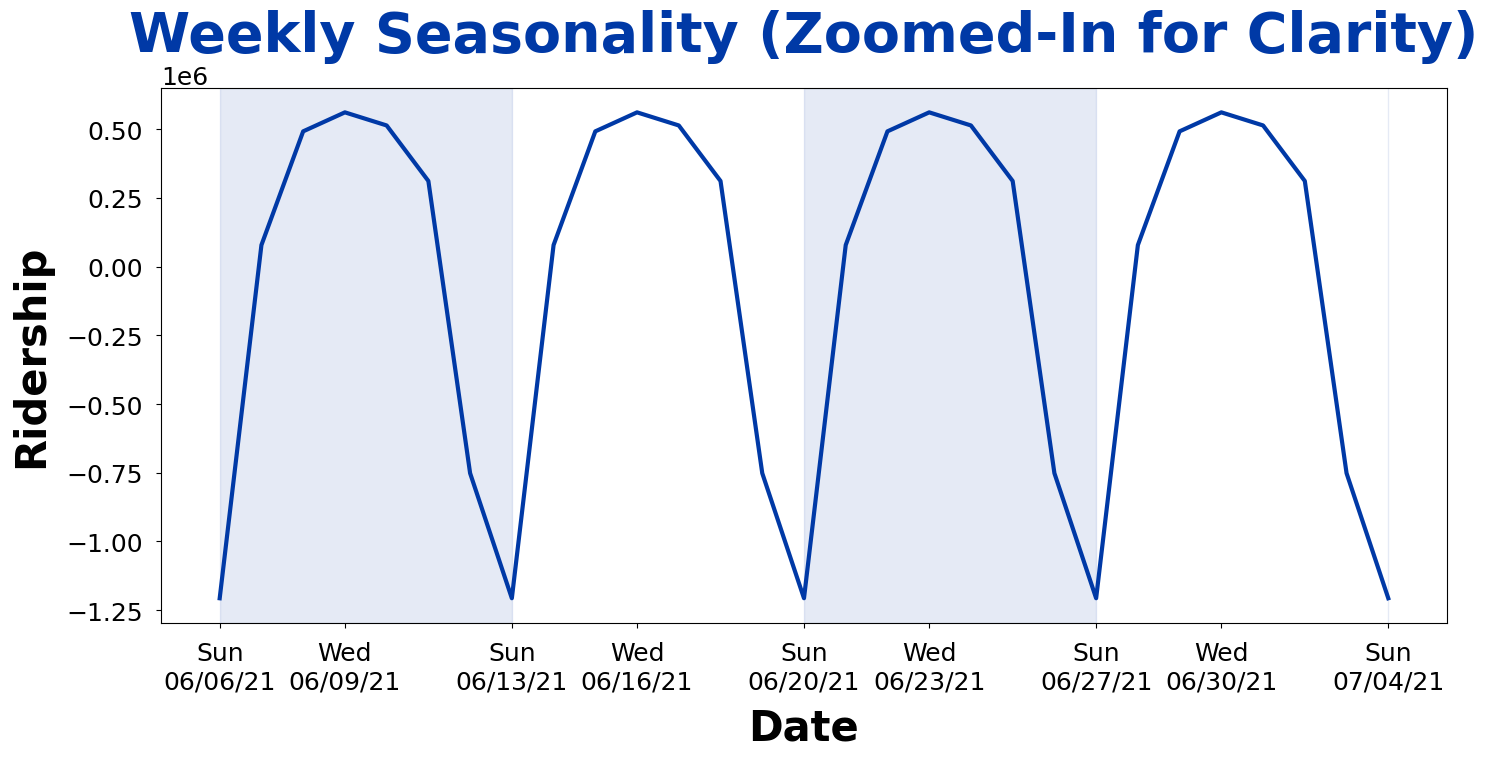

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

# Set font to Helvetica and increase font sizes
plt.rcParams['font.size'] = 20  # base font size
plt.rcParams['axes.titlesize'] = 20  # title font size
plt.rcParams['axes.labelsize'] = 20  # axis label font size
plt.rcParams['xtick.labelsize'] = 18  # x-axis tick label size
plt.rcParams['ytick.labelsize'] = 18  # y-axis tick label size

plt.figure(figsize=(15, 8))
plt.plot(decomposition.seasonal[5:34], color='#0039a6', linewidth=3)

# Custom formatter to show day name and date
def day_date_formatter(x, pos=None):
    date = mdates.num2date(x)
    if date.weekday() == 6:  # Sunday
        return f"Sun\n{date.strftime('%m/%d/%y')}"
    elif date.weekday() == 2:  # Wednesday
        return f"Wed\n{date.strftime('%m/%d/%y')}"
    return ""

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(day_date_formatter))

# Custom locator to place ticks on Sundays and Wednesdays
class SunWedLocator(mdates.DayLocator):
    def __init__(self):
        super().__init__(interval=1)

    def __call__(self):
        ticks = super().__call__()
        return [t for t in ticks if mdates.num2date(t).weekday() in (2, 6)]

plt.gca().xaxis.set_major_locator(SunWedLocator())

dates = decomposition.seasonal[5:34].index
start_date, end_date = min(dates), max(dates)

# Shade every other week
shade = False
for i, date in enumerate(dates):
    if date.weekday() == 6:
        if i > 0:
            end_date = date
            plt.axvspan(start_date, end_date,
                       color='#0039a6', alpha=0.1 if shade else 0)
        start_date = date
        shade = not shade

# Shade the last week if necessary
if shade:
    plt.axvspan(start_date, dates[-1], color='#0039a6', alpha=0.1)

plt.title('Weekly Seasonality (Zoomed-In for Clarity)', fontsize=40, fontweight='bold', color='#0039a6', pad=10)
plt.xlabel('Date', fontsize=30, labelpad=10, fontweight='bold')
plt.ylabel('Ridership', fontsize=30, labelpad=10, fontweight='bold')

# Adjust tick label padding
plt.gca().tick_params(axis='x', which='major', pad=10)
plt.gca().tick_params(axis='y', which='major', pad=10)

plt.tight_layout()
plt.show()

The graph clearly illustrates a recurring weekly pattern, with Sundays consistently representing the lowest points (trough) in the seasonal cycle.

#### 2.5.3 Residual Analysis

Residuals are calculated by taking the observed value and subtracting the predicted value. It's important to analyze the decomposition residuals to understand the validity / reliability of the model.

In [18]:
def plot_residuals(residuals):

    # Create a figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Scatterplot of residuals
    ax1.scatter(residuals.index, residuals)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.set_title("Scatterplot of Residuals")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Residuals')

    # Histogram of residuals
    n, bins, patches = ax2.hist(residuals, bins=30, edgecolor='black', alpha=0.7, density=True)
    ax2.set_title("Histogram of Residuals")
    ax2.set_xlabel('Residuals')
    ax2.set_ylabel('Density')

    # Add a red line for the theoretical normal distribution
    mu, std = residuals.mean(), residuals.std()
    xmin, xmax = ax2.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax2.plot(x, p, 'r', linewidth=2, label='Theoretical Normal Distribution')
    ax2.legend()

    # Q-Q plot of residuals
    sm.qqplot(residuals, line='s', ax=ax3)
    ax3.set_title("Q-Q Plot of Residuals")

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

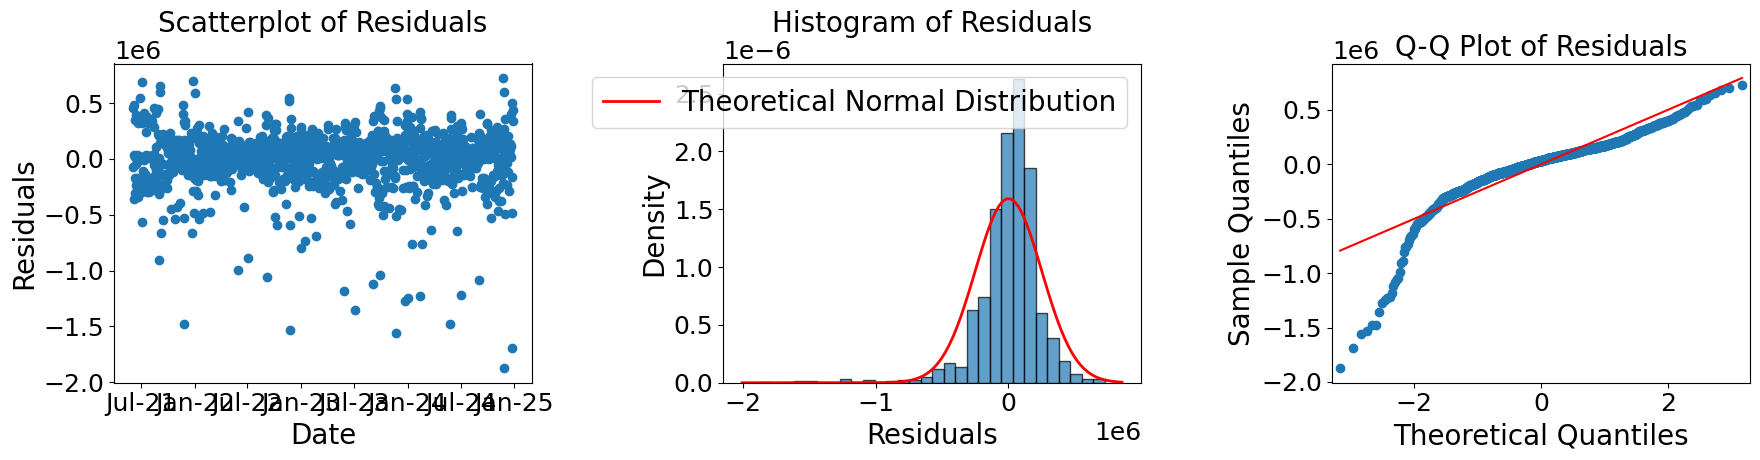

In [19]:
plot_residuals(decomposition.resid.dropna())

The residuals of the decomposition display homoskedasticity (constant variance across the range of predictions) and linearity, which are positive properties. However, the residuals have a left (negative) skew, which is evident in the left side of the histogram and Q-Q plot. This indicates that the decomposition may be missing some underlying patterns in the data. Because the residuals have a negative skew, it means that there are instances where the model is overpredicting ridership.

Some of the largest residuals occur around the end of the year due to the holiday season drastically reducing ridership from expected levels, which is likely the main reason that this pattern is occurring.

## 3. Statistical Testing

### 3.1 Test for Stationarity

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or not. Stationarity means that the statistical properties of the series (like mean, variance, and autocorrelation) do not change over time. If a series is stationary, it’s easier to model and analyze.

Using the Augmented Dickey-Fuller (ADF) test, I test for the stationarity, which is the underlying assumption for many time series models.

In [20]:
adft = adfuller(daily, autolag="AIC", regression='c')
adf_results = pd.DataFrame({
    "Values":[f"{adft[0]:.4f}",f"{adft[1]:.4f}",adft[2],adft[3]],
    "Metric":["Test Statistic","p-value","No. of lags used","Number of observations used"]})
adf_results

,Values,Metric
0,-3.1467,Test Statistic
1,0.0233,p-value
2,21,No. of lags used
3,1288,Number of observations used


The ADF test results suggest that the daily ridership time series data is stationary at the 0.05 significance level. Theoretically, this contradicts the earlier findings of a statistically significant, moderate trend in the data. However, the deterministic trend discovered earlier may be weak enough that stationarity still holds.

In [21]:
adft = adfuller(daily, autolag="AIC", regression="ct")
adf_results = pd.DataFrame({
    "Values":[f"{adft[0]:.4f}",f"{adft[1]:.4f}",adft[2],adft[3]],
    "Metric":["Test Statistic","p-value","No. of lags used","Number of observations used"]})
adf_results

,Values,Metric
0,-4.7082,Test Statistic
1,0.0007,p-value
2,21,No. of lags used
3,1288,Number of observations used


In this second iteration, the regression type was "ct", meaning that the test allows for the possibility that the data has both a constant and trend. Considering that the p-value is lower with the trend considered, this suggests that there is some trend in the data, but it’s not strong enough to make the data non-stationary. In other words, the trend is small and doesn’t dominate the overall behavior of the series.

Going forward, it *may* make sense to de-trend the data, but there's also a risk of overfitting to our training data, considering the trend is seemingly of low significance to the analysis.

### 3.2 Autocorrelation Analysis

In [22]:
autocorr_results = pd.DataFrame({
    'Lag': [1, 7, 30],
    'Autocorrelation': [daily['ridership'].autocorr(lag=1),
                        daily['ridership'].autocorr(lag=7),
                        daily['ridership'].autocorr(lag=30)]
    })
autocorr_results

,Lag,Autocorrelation
0,1,0.58
1,7,0.87
2,30,-0.02


The results from the above table indicate that there is a moderate correlation on a one-day lag, a strong correlation on a seven-day lag, and a negligible correlation at a one-month lag

## 4. Time Series Modeling

### 4.1 Training & Testing Data

To start, let's divide the data between training and testing data. The last three months of the data will be used as testing data, and the rest will be for training the model. (Close to a 90/10 split)

In [23]:
split_date = pd.to_datetime('2024-09-30')
training = daily[daily.index <= split_date]
testing = daily[daily.index > split_date]
assert len(training) + len(testing) == len(daily)

In [24]:
training[training.isna().any(axis=1)]

,ridership
date,


### 4.2 Holt-Winters Exponential Smoothing

#### 4.2.1 Finding the Best Parameters

To start, let's test whether an additive or multiplicative component is more accurate for the model.

In [25]:
# Define the options and generate permutations
options = ['multiplicative', 'additive', None]
permutations = list(itertools.product(options, options))

# Create an empty list to store the results
results = []

# Ignore convergence warning
warnings.simplefilter('ignore', ConvergenceWarning)
testing = testing.squeeze()
training = training.squeeze()

# Loop through each permutation to test results
for perm in permutations:
    model = ExponentialSmoothing(training, trend=perm[0], seasonal=perm[1],
                                  freq='D', seasonal_periods=7)
    fit = model.fit()

    predictions = fit.forecast(len(testing))

    mae = mean_absolute_error(testing, predictions)
    rmse = np.sqrt(mean_squared_error(testing, predictions))
    mape = np.mean(np.abs((testing - predictions) / testing)) * 100

    results.append({'Trend': perm[0],
                    'Seasonal': perm[1],
                    'AIC': fit.aic,
                    'MAE': mae,
                    'RMSE': rmse,
                    'MAPE': mape})

results_df = pd.DataFrame(results).sort_values('MAE').reset_index(drop=True)

In [29]:
# Styling results for readability
results = results_df.style.format({
    'AIC': '{:,.0f}',
    'MAE': '{:,.0f}',
    'RMSE': '{:,.0f}',
    'MAPE': '{:.2f}%'
})
results

,Trend,Seasonal,AIC,MAE,RMSE,MAPE
0,None,multiplicative,"30,576","288,341","554,598",11.29%
1,None,additive,"30,609","308,007","542,268",11.80%
2,multiplicative,additive,"30,634","520,342","819,477",19.97%
3,multiplicative,multiplicative,"30,599","529,941","858,823",19.36%
4,additive,multiplicative,"30,590","583,115","906,226",20.96%
5,additive,additive,"30,626","610,120","903,844",22.88%
6,multiplicative,None,"32,928","783,635","873,880",26.91%
7,additive,None,"32,924","785,621","871,349",26.78%
8,None,None,"32,911","799,270","873,299",26.25%


#### 4.2.2.a Predicting w/ Best Model

In [30]:
model = ExponentialSmoothing(training, seasonal='mul',
                              freq='D', seasonal_periods=7)
fit = model.fit(optimized=True)

# getting predicted values
forecast = fit.forecast(steps=len(testing))

# printing summary of model
fit.summary()

Dep. Variable:,ridership,No. Observations:,1218
Model:,ExponentialSmoothing,SSE,95805985625200.703
Optimized:,True,AIC,30575.648
Trend:,None,BIC,30621.593
Seasonal:,Multiplicative,AICC,30575.867
Seasonal Periods:,7,Date:,"Thu, 17 Apr 2025"
Box-Cox:,False,Time:,19:55:53
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3350000,alpha,True
smoothing_seasonal,0.0380000,gamma,True


In conclusion, the better ES model of the two uses multiplicative seasonality with no trend.

#### 4.2.3 Residuals Analysis

Let's start by plotting the residuals for the Holt-Winters model.

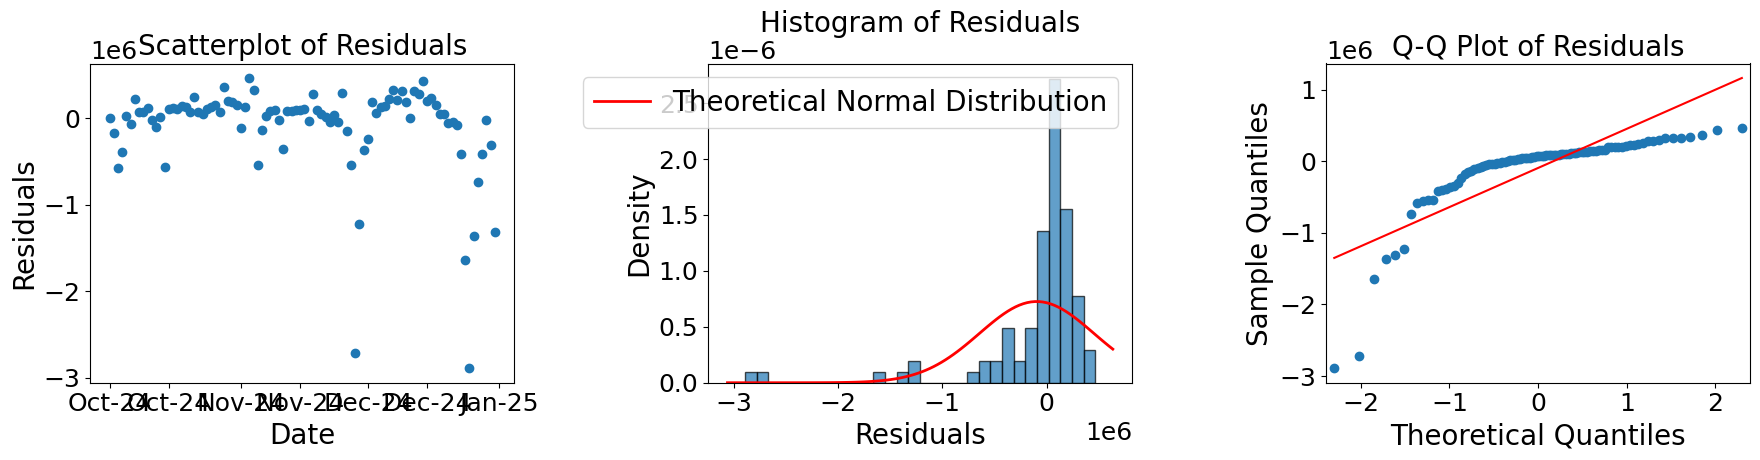

In [31]:
residuals = testing - forecast
plot_residuals(residuals)

These aren't healthy residuals because there's a very strong negative skew, and the Q-Q plot shows that the residuals are not normally distributed.

However, based on the location of the largest residuals on the scatterplot, it seems fairly obvious that holidays are playing a huge role in the issue.

In [32]:
top_residuals = pd.DataFrame(residuals.sort_values().head(10))

top_residuals.columns = ['Residuals']
top_residuals['Exception'] = ["Christmas Day", "Thanksgiving", "Christmas Eve",
                              "Christmas season", "New Year's Eve",
                              "Black Friday", "Christmas season",
                              "Columbus Day", "N/A", "Election Day"]
top_residuals

,Residuals,Exception
date,,
2024-12-25,-2891190.96,Christmas Day
2024-11-28,-2714189.93,Thanksgiving
2024-12-24,-1641111.22,Christmas Eve
2024-12-26,-1360597.93,Christmas season
2024-12-31,-1311887.22,New Year's Eve
2024-11-29,-1227902.83,Black Friday
2024-12-27,-734755.83,Christmas season
2024-10-03,-577645.93,Columbus Day
2024-10-14,-558602.05,N/A


The table above demonstrates that all but one of the top 10 residuals coincide with a major US holiday.

Let's plot what the residuals would look like without the top 8 residuals, which represent clear dips due to holidays.

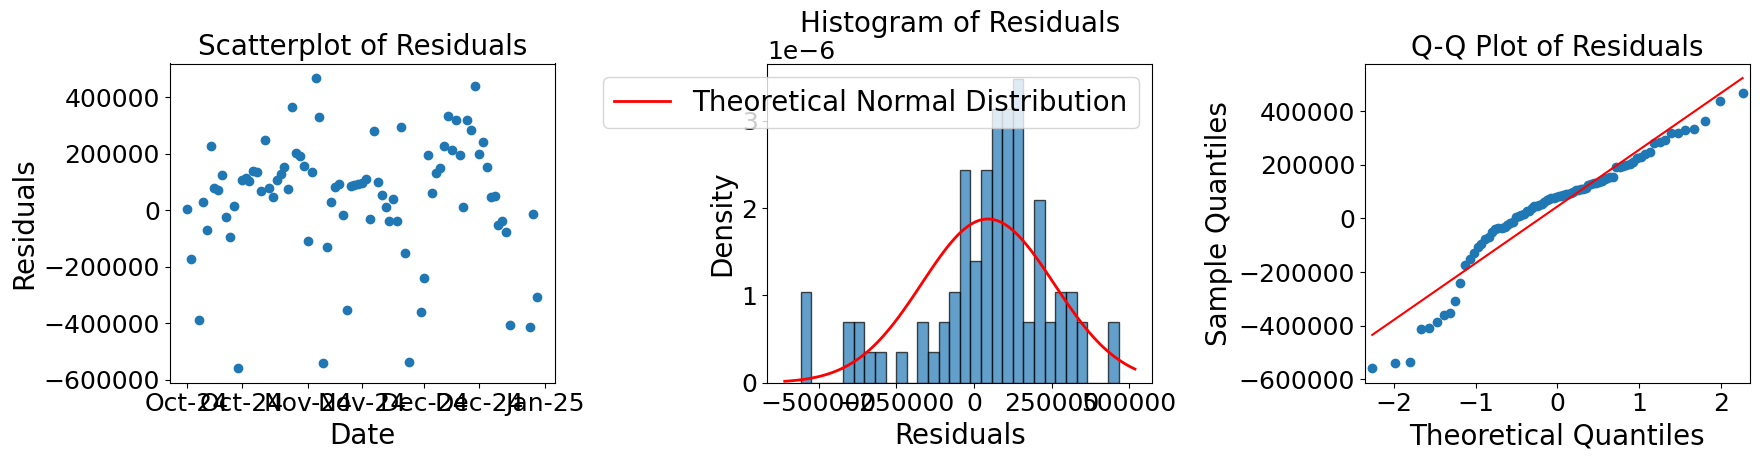

In [33]:
residuals_filtered = residuals.sort_values()[8:]
plot_residuals(residuals_filtered)

It's clear that adding holidays as a predictor somehow would be helpful for significantly improving the performance of this model, and bringing the residuals to a better spot.

### 4.3 ARIMA/SARIMA Modeling

The following usees auto_arima to find the best hyper-parameters for a SARIMA model

In [34]:
#auto_model = auto_arima(train['ridership'], seasonal=True, m=7, stepwise=True, supress_warnings=True, trace=True)
#auto_results = auto_model.fit(disp=False)
#auto_model.summary()

The following code creates the model based on the best hyper-parameters determined above.

In [35]:
model = SARIMAX(training, order=(3, 1, 2),
                seasonal_order=(2, 0, 2, 7),
                freq='D')

results = model.fit()
results.summary()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41389D+01    |proj g|=  2.64750D-01

At iterate    5    f=  1.40450D+01    |proj g|=  3.32279D-02

At iterate   10    f=  1.40291D+01    |proj g|=  3.93335D-03

At iterate   15    f=  1.40284D+01    |proj g|=  4.68321D-03

At iterate   20    f=  1.40284D+01    |proj g|=  1.95522D-04

At iterate   25    f=  1.40282D+01    |proj g|=  3.68252D-03

At iterate   30    f=  1.40279D+01    |proj g|=  2.02480D-03

At iterate   35    f=  1.40278D+01    |proj g|=  2.41193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         ridership   No. Observations:                 1218
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -17085.837
Date:                           Thu, 17 Apr 2025   AIC                          34191.674
Time:                                   19:55:56   BIC                          34242.715
Sample:                               06-01-2021   HQIC                         34210.887
                                    - 09-30-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4823      0.647     -0.745      0.456      -1.751       0.786
ar.L2          0.3645      0.260      1.400      0.161      -0.146       0.875
ar.L3          0.0143      0.072      0.198      0.843      -0.127       0.155
ma.L1         -0.0332      0.647     -0.051      0.959      -1.302       1.236
ma.L2         -0.7755      0.591     -1.312      0.189      -1.934       0.383
ar.S.L7        0.2236      0.331      0.676      0.499      -0.425       0.872
ar.S.L14       0.7745      0.331      2.343      0.019       0.127       1.422
ma.S.L7       -0.1345      0.308     -0.437      0.662      -0.738       0.469
ma.S.L14      -0.7660      0.290     -2.640      0.008      -1.335      -0.197
sigma2      1.356e+11   7.78e-11   1.74e+21      0.000    1.36e+11    1.36e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):             10804.41
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -2.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.7e+36. Standard errors may be unstable.
"""

This code creates the predicted values for the test dataset.

In [36]:
forecast = results.get_forecast(steps=len(testing))
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

The following code graphs the prediction (forecast) against the observed (actual) along with the confidence intervals in a lighter red.

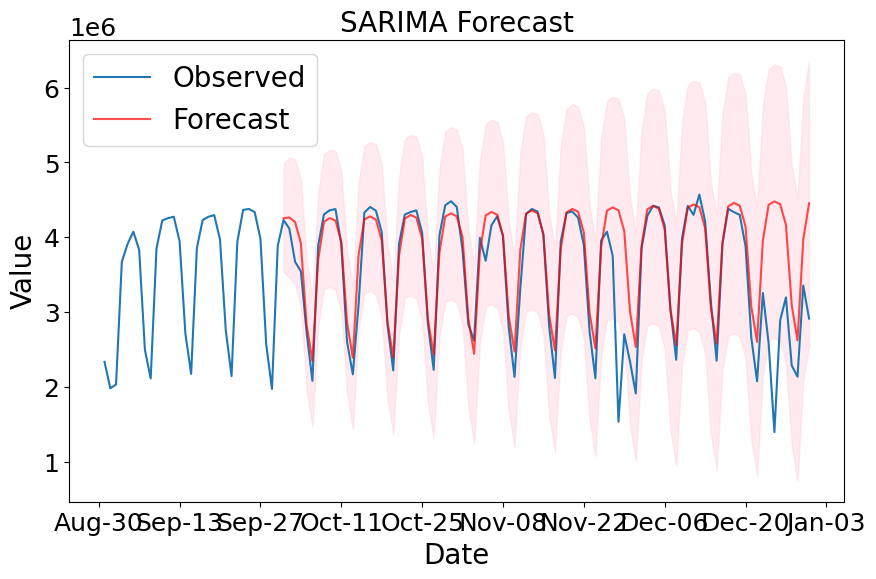

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(daily[daily.index >= pd.to_datetime('2024-08-31')], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:,0], confidence_intervals.iloc[:,1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

The graph above shows that the model was pretty accurate until the end of the year (Christmas / holiday season) where it significantly over-predicted ridership.

The model's residuals have a similar issue to previous models with holidays seemingly representing the largest cause of unexplained variance.

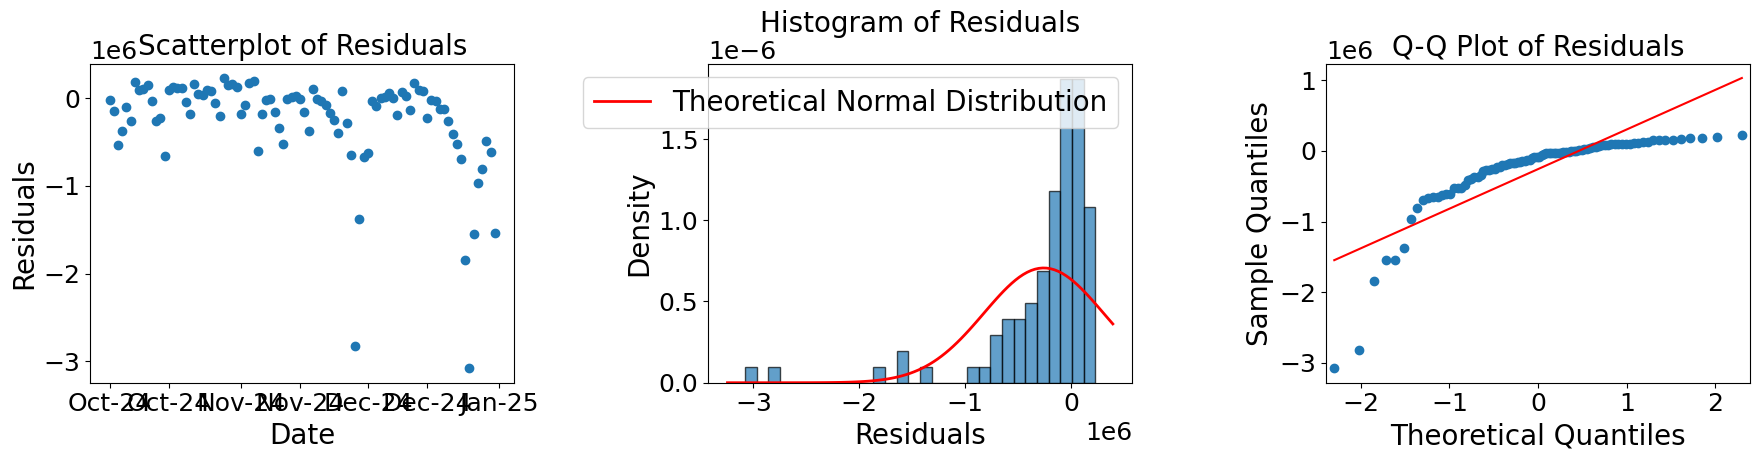

In [38]:
testing = testing.squeeze()
forecast_mean = forecast_mean.squeeze()

residuals = testing - forecast_mean
plot_residuals(residuals)

In [39]:
mae = mean_absolute_error(testing, forecast_mean)
rmse = np.sqrt(mean_squared_error(testing, forecast_mean))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 326719.88
RMSE: 617654.10


The RMSE is higher than the Holt-Winters Exponential Smoothing model, which means that the model's predictions are on average futher away from the observed (actual) value.